In [57]:
from tensorflow.keras.datasets import fashion_mnist

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import time

In [59]:
from tensorflow import keras
from tensorflow.keras.layers import Dense,Conv2D,Activation,Flatten,MaxPooling2D

In [60]:
! pip install -U keras-tuner
import kerastuner
import tensorflow
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

Requirement already up-to-date: keras-tuner in /usr/local/lib/python3.6/dist-packages (1.0.1)


In [78]:
(x_train,y_train),(x_test,y_test) = fashion_mnist.load_data()

In [62]:
x_train.shape

(60000, 28, 28)

In [63]:
x_train[...,np.newaxis].shape

(60000, 28, 28, 1)

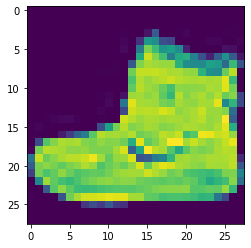

In [64]:
plt.imshow(x_train[0])

In [79]:
x_train = x_train[...,np.newaxis]
x_test = x_test[...,np.newaxis]

In [66]:
x_train.shape[1:]

(28, 28, 1)

In [67]:
def build_model():
  model = keras.Sequential()

  model.add(Conv2D(32,(3,3), input_shape = x_train.shape[1:]))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Flatten())

  model.add(Dense(10))
  model.add(Activation('softmax'))

  model.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model



In [68]:
model = build_model()
history = model.fit(x_train,y_train,batch_size=64,epochs=5, validation_data=(x_test,y_test))

Epoch 1/5
938/938 [==============================] - 6s 6ms/step - loss: 1.6656 - accuracy: 0.7869 - val_loss: 0.6143 - val_accuracy: 0.8281
Epoch 2/5
938/938 [==============================] - 5s 6ms/step - loss: 0.4501 - accuracy: 0.8510 - val_loss: 0.4405 - val_accuracy: 0.8500
Epoch 3/5
938/938 [==============================] - 6s 6ms/step - loss: 0.3693 - accuracy: 0.8681 - val_loss: 0.4128 - val_accuracy: 0.8581
Epoch 4/5
938/938 [==============================] - 6s 6ms/step - loss: 0.3421 - accuracy: 0.8758 - val_loss: 0.3865 - val_accuracy: 0.8646
Epoch 5/5
938/938 [==============================] - 6s 6ms/step - loss: 0.3241 - accuracy: 0.8828 - val_loss: 0.3814 - val_accuracy: 0.8645


## Keras optimizers

In [69]:
LOG_DIR = f"{int(time.time())}"

In [70]:
def build_model_2(hp):
  model = keras.Sequential()

  model.add(Conv2D(hp.Int("input_units",min_value=32,max_value=256,step=32),(3,3), input_shape = x_train.shape[1:]))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  for i in range(hp.Int("n_conv_layer",1,15)):
    model.add(Conv2D(hp.Int(f"conv_{i}_units",min_value=16,max_value=256,step=2),(3,3)))
    model.add(Activation('relu'))
    
  model.add(Flatten())

  #for i in range(hp.Int("n_hidden_layer",min_value=0,max_value=5)):
  #  model.add(Dense(hp.Int(f"hidden_{i}_units",0,50,1)))
  #  model.add(Activation('relu'))

  model.add(Dense(10))
  model.add(Activation('softmax'))

  

  model.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model


In [71]:
tuner = RandomSearch(
    build_model_2,
    objective = 'val_accuracy',
    max_trials = 1,
    executions_per_trial = 1,
    directory = LOG_DIR
)

tuner.search(
    x=x_train,
    y=y_train,
    epochs = 5,
    batch_size = 64,
    validation_data = (x_test,y_test)
)

Epoch 1/5
938/938 [==============================] - 12s 13ms/step - loss: 0.7512 - accuracy: 0.8404 - val_loss: 0.3552 - val_accuracy: 0.8744
Epoch 2/5
938/938 [==============================] - 12s 13ms/step - loss: 0.3067 - accuracy: 0.8895 - val_loss: 0.3424 - val_accuracy: 0.8758
Epoch 3/5
938/938 [==============================] - 12s 13ms/step - loss: 0.2717 - accuracy: 0.9025 - val_loss: 0.3178 - val_accuracy: 0.8860
Epoch 4/5
938/938 [==============================] - 12s 13ms/step - loss: 0.2500 - accuracy: 0.9099 - val_loss: 0.3240 - val_accuracy: 0.8865
Epoch 5/5
938/938 [==============================] - 12s 13ms/step - loss: 0.2353 - accuracy: 0.9143 - val_loss: 0.3443 - val_accuracy: 0.8852


INFO:tensorflow:Oracle triggered exit


In [82]:
models = tuner.get_best_models()[0]
models.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 96)        960       
_________________________________________________________________
activation (Activation)      (None, 26, 26, 96)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 56)        48440     
_________________________________________________________________
activation_1 (Activation)    (None, 11, 11, 56)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 16)          8080      
_________________________________________________________________
activation_2 (Activation)    (None, 9, 9, 16)          0

In [73]:
tuner.results_summary()


In [80]:
tuner = kerastuner.Hyperband(build_model_2,
                     objective = 'val_accuracy', 
                     max_epochs = 50,
                     factor = 3,
                     directory = LOG_DIR,
                     project_name = 'intro_to_kt')


class ClearTrainingOutput(tensorflow.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    print("Ended")
    #IPython.display.clear_output(wait = True)


tuner.search(x_train,y_train, epochs = 5, validation_data = (x_test, y_test))

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")



INFO:tensorflow:Reloading Oracle from existing project 1599412247/intro_to_kt/oracle.json
INFO:tensorflow:Reloading Tuner from 1599412247/intro_to_kt/tuner0.json


Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py", line 1812, in _create_c_op
    c_op = pywrap_tf_session.TF_FinishOperation(op_desc)
tensorflow.python.framework.errors_impl.InvalidArgumentError: Negative dimension size caused by subtracting 3 from 1 for '{{node conv2d_7/Conv2D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](activation_6/Relu, conv2d_7/Conv2D/ReadVariableOp)' with input shapes: [?,1,1,170], [3,3,170,16].

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/kerastuner/engine/hypermodel.py", line 105, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-70-056255a0ac62>", line 9, in build_model_2
    model.add(Conv2D(hp.Int(f"conv_{i}_units",min_value=16,max_value=256,step=2),(3,3)))
  Fi

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py", line 1812, in _create_c_op
    c_op = pywrap_tf_session.TF_FinishOperation(op_desc)
tensorflow.python.framework.errors_impl.InvalidArgumentError: Negative dimension size caused by subtracting 3 from 1 for '{{node conv2d_7/Conv2D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](activation_6/Relu, conv2d_7/Conv2D/ReadVariableOp)' with input shapes: [?,1,1,170], [3,3,170,16].

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/kerastuner/engine/hypermodel.py", line 105, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-70-056255a0ac62>", line 9, in build_model_2
    model.add(Conv2D(hp.Int(f"conv_{i}_units",min_value=16,max_value=256,step=2),(3,3)))
  Fi

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py", line 1812, in _create_c_op
    c_op = pywrap_tf_session.TF_FinishOperation(op_desc)
tensorflow.python.framework.errors_impl.InvalidArgumentError: Negative dimension size caused by subtracting 3 from 1 for '{{node conv2d_7/Conv2D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](activation_6/Relu, conv2d_7/Conv2D/ReadVariableOp)' with input shapes: [?,1,1,170], [3,3,170,16].

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/kerastuner/engine/hypermodel.py", line 105, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-70-056255a0ac62>", line 9, in build_model_2
    model.add(Conv2D(hp.Int(f"conv_{i}_units",min_value=16,max_value=256,step=2),(3,3)))
  Fi

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py", line 1812, in _create_c_op
    c_op = pywrap_tf_session.TF_FinishOperation(op_desc)
tensorflow.python.framework.errors_impl.InvalidArgumentError: Negative dimension size caused by subtracting 3 from 1 for '{{node conv2d_7/Conv2D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](activation_6/Relu, conv2d_7/Conv2D/ReadVariableOp)' with input shapes: [?,1,1,170], [3,3,170,16].

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/kerastuner/engine/hypermodel.py", line 105, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-70-056255a0ac62>", line 9, in build_model_2
    model.add(Conv2D(hp.Int(f"conv_{i}_units",min_value=16,max_value=256,step=2),(3,3)))
  Fi

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py", line 1812, in _create_c_op
    c_op = pywrap_tf_session.TF_FinishOperation(op_desc)
tensorflow.python.framework.errors_impl.InvalidArgumentError: Negative dimension size caused by subtracting 3 from 1 for '{{node conv2d_7/Conv2D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](activation_6/Relu, conv2d_7/Conv2D/ReadVariableOp)' with input shapes: [?,1,1,170], [3,3,170,16].

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/kerastuner/engine/hypermodel.py", line 105, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-70-056255a0ac62>", line 9, in build_model_2
    model.add(Conv2D(hp.Int(f"conv_{i}_units",min_value=16,max_value=256,step=2),(3,3)))
  Fi

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py", line 1812, in _create_c_op
    c_op = pywrap_tf_session.TF_FinishOperation(op_desc)
tensorflow.python.framework.errors_impl.InvalidArgumentError: Negative dimension size caused by subtracting 3 from 1 for '{{node conv2d_7/Conv2D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](activation_6/Relu, conv2d_7/Conv2D/ReadVariableOp)' with input shapes: [?,1,1,170], [3,3,170,16].

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/kerastuner/engine/hypermodel.py", line 105, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-70-056255a0ac62>", line 9, in build_model_2
    model.add(Conv2D(hp.Int(f"conv_{i}_units",min_value=16,max_value=256,step=2),(3,3)))
  Fi

RuntimeError: ignored